## Generating an eigenpulse timeseries from known pulsar timeseries

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import dedispersion
#import filterbankio
SOURCE_PATH = '/home/inigo/pulseClassifier/src/'
import imp #importing package
dedispersion = imp.load_source('dedispersion', SOURCE_PATH + 'dedispersion.py')
filterbankio = imp.load_source('filterbankio', SOURCE_PATH + 'filterbankio.py')


In [3]:
pulsarpath = '/data2/griffin/ALFABURST/pulses'
pulsebanks = glob.glob(pulsarpath + '/*.fil')
print 'There are %d pulses in ' %(len(pulsebanks)) + pulsarpath

There are 685 pulses in /data2/griffin/ALFABURST/pulses


### Parameters

In [4]:
# standards
timeFactor = 1
freqFactor = 1

start_time = 0. # seconds
time_window = None # seconds

applyGauss = True
fGauss = 2. # bins
tGauss = 2. # bins

### Load Filterbank

In [5]:
sumtimeseries = np.zeros(32768)
pulsecount = 0

for frbFil in pulsebanks:
    
    fil = filterbankio.Filterbank(frbFil)

    tInt = fil.header['tsamp'] # get tInt
#     print tInt
    freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

    waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape filterbank data 
    #to (n integrations, n freqs)

#     print tInt*1000. * 8
#     print (fil.freqs[0] - fil.freqs[1])*8veronica vasicka

    # Time Decimation
    # average down by N time samples
    if waterfall.shape[0] % timeFactor==0: #if there's no remainder when dividing by timefactor
        decwaterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor,\
                                            waterfall.shape[1]).sum(axis=1) #reshape previously reshaped fil.data
        tInt *= timeFactor
    else:
        print 'WARNING: %i time samples is NOT divisible by %i, zero-padding spectrum to usable size'%(waterfall.shape[0], timeFactor)
        zeros = np.zeros((timeFactor - (waterfall.shape[0] % timeFactor), waterfall.shape[1]))
        decwaterfall = np.concatenate((waterfall, zeros))
        decwaterfall = decwaterfall.reshape(decwaterfall.shape[0]/timeFactor, timeFactor,\
                                         decwaterfall.shape[1]).sum(axis=1)
        tInt *= timeFactor

    # Frequency Decimation
    if decwaterfall.shape[1] % freqFactor==0:
        decwaterfall = decwaterfall.reshape(decwaterfall.shape[0], decwaterfall.shape[1]/freqFactor,\
                                            freqFactor).sum(axis=2)
        freqsHz = freqsHz[::freqFactor]
    else:
        print 'WARNING: %i frequency channels is NOT divisible by %i, ignoring option'%(decwaterfall.shape[1],\
                                                                                        freqFactor)

    if start_time is None: startIdx = 0
    else: startIdx = int(start_time / tInt)

    if time_window is None:
        endIdx = decwaterfall.shape[0]
    else:
        endIdx = startIdx + int(time_window / tInt)
        if endIdx > decwaterfall.shape[0]:
            print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
            endIdx = decwaterfall.shape[0]

    decwaterfall = decwaterfall[startIdx:endIdx,:]
    
    timeseries = np.sum(decwaterfall, axis=1)
    if len(timeseries) == 32768:
        sortedtimeseries = np.sort(timeseries)
        sumtimeseries += sortedtimeseries
        pulsecount += 1


### Sum over all pulses and create an average pulse profile

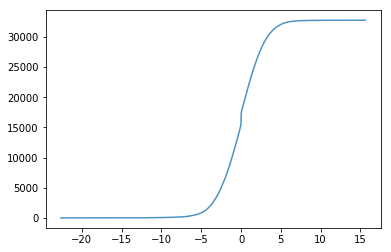

In [6]:
eigenpulse = sumtimeseries/pulsecount
arbitraryY = range(np.size(sortedtimeseries))
plt.plot(eigenpulse, arbitraryY, alpha=0.8)
np.save('eigenpulse', eigenpulse, allow_pickle=True, fix_imports=True)

### Plot the eigenpulse

(65536, 256)


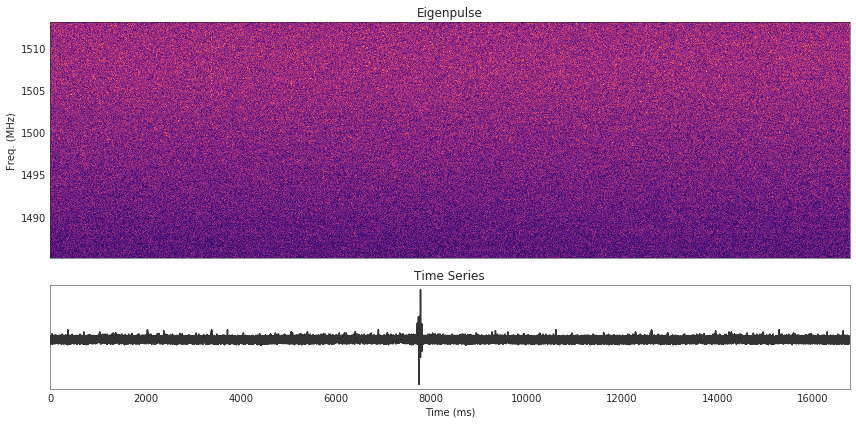

In [7]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

#plt.style.use('dark_background')

fig = plt.figure(figsize=(12,6)) # (width, height)
#fig = plt.figure(figsize=(5,4.5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decwaterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
print decwaterfall.shape

plt.title('Eigenpulse')
plt.ylabel('Freq. (MHz)')
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
#lineColor = 'w'
plt.plot(1000.*tInt*np.arange(decwaterfall.shape[0]), timeseries, lineColor, alpha=0.8) #plt.plot(x,y)
plt.xlim(0, 1000.*tInt*timeseries.shape[0])
plt.title('Time Series')
plt.xlabel('Time (ms)')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('eigenpulse.pdf')